Mounting google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries

In [2]:
# Import libraries
import pandas as pd
import requests
import time
from datetime import datetime
import matplotlib.pyplot as plt


# Geocode addressing and Fetch weather functions

In [3]:
#Caches for geocoding and weather results
geocode_cache = {}
weather_cache = {}

def geocode_address(address, city=None):
    """
    Geocode an address using public Nominatim API, with caching.
    Returns (latitude, longitude) or (None, None) if failed.
    """
    query = f"{address}, {city}, Connecticut" if city else f"{address}, Connecticut"
    if query in geocode_cache:
        return geocode_cache[query]

    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': query,
        'format': 'json',
        'limit': 1,
        'addressdetails': 1,
        'countrycodes': 'us'
    }
    headers = {
        'User-Agent': 'MyGeocodingTestApp/1.0 (student@lab6)'
    }

    try:
        response = requests.get(base_url, params=params, headers=headers)
        print(f"Status code for '{query}': {response.status_code}")
        if response.status_code == 200:
            data = response.json()
            if data:
                lat = float(data[0]['lat'])
                lon = float(data[0]['lon'])
                geocode_cache[query] = (lat, lon)
                return lat, lon
            else:
                print(f"No results for '{query}'")
                geocode_cache[query] = (None, None)
                return None, None
        else:
            print(f"Error for '{query}': {response.status_code}, {response.text}")
            geocode_cache[query] = (None, None)
            return None, None
    except requests.RequestException as e:
        print(f"Request failed for '{query}': {e}")
        geocode_cache[query] = (None, None)
        return None, None

    time.sleep(1)  #Nominatim's 1 request/second limit

def fetch_weather(lat, lon, date):
    """
    Fetch max temperature (C) and precipitation (mm) for a date using Open Meteo Archive API.
    Returns (max_temp, precip) or (None, None) if failed.
    """
    if lat is None or lon is None:
        print(f"Skipping weather fetch: Invalid coordinates (lat={lat}, lon={lon})")
        return None, None

    cache_key = (round(lat, 4), round(lon, 4), date.strftime('%Y-%m-%d'))
    if cache_key in weather_cache:
        return weather_cache[cache_key]

    base_url = "https://archive-api.open-meteo.com/v1/archive"
    date_str = date.strftime('%Y-%m-%d')
    params = {
        'latitude': lat,
        'longitude': lon,
        'start_date': date_str,
        'end_date': date_str,
        'daily': 'temperature_2m_max,precipitation_sum',
        'timezone': 'America/New_York'
    }

    try:
        response = requests.get(base_url, params=params)
        print(f"Weather API status for lat={lat}, lon={lon}, date={date_str}: {response.status_code}")
        if response.status_code == 200:
            data = response.json()
            if 'daily' in data and data['daily']['temperature_2m_max'] and data['daily']['precipitation_sum']:
                max_temp = data['daily']['temperature_2m_max'][0]
                precip = data['daily']['precipitation_sum'][0]
                weather_cache[cache_key] = (max_temp, precip)
                return max_temp, precip
            else:
                print(f"No weather data for lat={lat}, lon={lon}, date={date_str}")
                weather_cache[cache_key] = (None, None)
                return None, None
        else:
            print(f"Weather API error: {response.status_code}, {response.text}")
            weather_cache[cache_key] = (None, None)
            return None, None
    except requests.RequestException as e:
        print(f"Weather request failed: {e}")
        weather_cache[cache_key] = (None, None)
        return None, None

    time.sleep(0.5)  #Open Meteo 0.5 second delay per request

# Loading Initial dataset and Filter and Generate new dataset

In [4]:

#Load the dataset
csv_file = '/content/drive/MyDrive/Informatics-INFO8000/Data/real_estate.csv'
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    print(f"Error: File '{csv_file}' not found.")
    exit(1)
except pd.errors.EmptyDataError:
    print("Error: CSV file is empty.")
    exit(1)

#print(df.shape)

#Filter for Mondays in April 2019
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], errors='coerce')
april_2019_mondays = df[
    (df['Date Recorded'].dt.year == 2019) &
    (df['Date Recorded'].dt.month == 4) &
    (df['Date Recorded'].dt.dayofweek == 0)
]

print(df.shape) #verifying that is fileted and reduced

#Remove rows with missing Address
filtered_data = april_2019_mondays[april_2019_mondays['Address'].notna()].copy()

#Geocode addresses missing latitude/longitude
if 'Latitude' not in filtered_data.columns:
    filtered_data['Latitude'] = pd.NA
if 'Longitude' not in filtered_data.columns:
    filtered_data['Longitude'] = pd.NA

for idx, row in filtered_data.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        continue

    address = row['Address']
    #city = row.get('Town')
    lat, lon = geocode_address(address)
    filtered_data.at[idx, 'Latitude'] = lat
    filtered_data.at[idx, 'Longitude'] = lon

#Drop rows with NaN latitude/longitude
geocoded_data = filtered_data.dropna(subset=['Latitude', 'Longitude']).copy()

#Fetch weather data
geocoded_data['Max_Temperature_C'] = pd.NA
geocoded_data['Precipitation_mm'] = pd.NA

for idx, row in geocoded_data.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    date = row['Date Recorded']
    max_temp, precip = fetch_weather(lat, lon, date)
    geocoded_data.at[idx, 'Max_Temperature_C'] = max_temp
    geocoded_data.at[idx, 'Precipitation_mm'] = precip

#final enhanced dataset
final_file = 'enhanced_real_estate_april_2019.csv'
geocoded_data.to_csv(final_file, index=False)
print(f"Final enhanced dataset saved to '{final_file}'.")

#Display first few rows to verify
print("\nFirst few rows of enhanced data:")
print(geocoded_data[['Address', 'Date Recorded', 'Town', 'Latitude', 'Longitude', 'Max_Temperature_C', 'Precipitation_mm']].head())

#Log failed geocoding
failed = filtered_data[filtered_data['Latitude'].isna()]['Address']
if not failed.empty:
    print("\nFailed addresses:", failed.tolist())



<ipython-input-4-45d8f6acb1db>:4: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


(1054159, 11)
Status code for '12 LILAC LA, Connecticut': 200
Status code for '626 MAIN ST, Connecticut': 200
Status code for '331 LEDGE DR, Connecticut': 200
Status code for '6 HICKORY LA, Connecticut': 200
Status code for '44 OLD ELLINGTON RD, Connecticut': 200
Status code for '242 MIDDLETOWN ROAD, Connecticut': 200
Status code for '5 JUNIPER RD, Connecticut': 200
Status code for '135, 137, 139 VALLEY DR, Connecticut': 200
No results for '135, 137, 139 VALLEY DR, Connecticut'
Status code for '69 BLACK ROCK AVE, Connecticut': 200
Status code for '57-59 DIVINITY ST, Connecticut': 200
Status code for '809 BIRMINGHAM CONDO, Connecticut': 200
No results for '809 BIRMINGHAM CONDO, Connecticut'
Status code for '118 GLENWOOD RD, Connecticut': 200
Status code for '101 RIDGEDALE ROAD, Connecticut': 200
Status code for '14 INDIAN WOODS RD, Connecticut': 200
Status code for '61 COURT D APT 61 BLDG 28 SUCC, Connecticut': 200
No results for '61 COURT D APT 61 BLDG 28 SUCC, Connecticut'
Status code

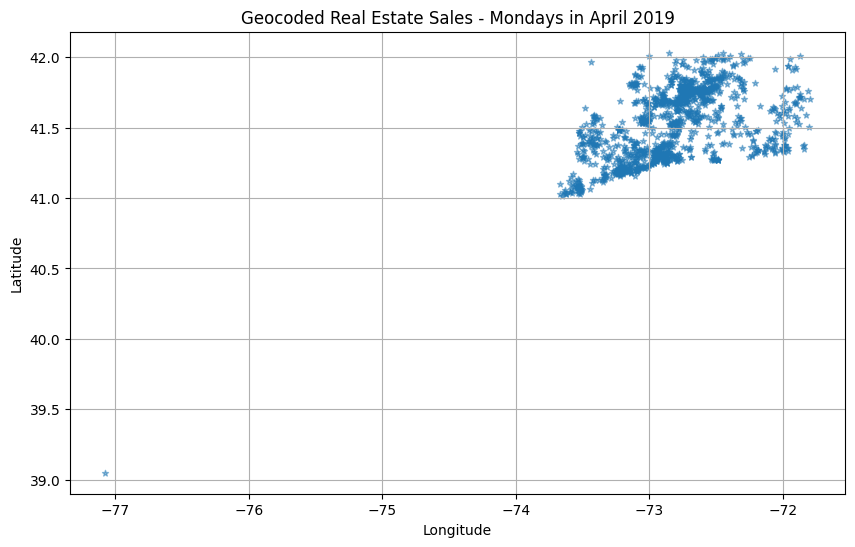

"\n#Save caches for reuse\nwith open('geocode_cache.json', 'w') as f:\n    json.dump({k: list(v) for k, v in geocode_cache.items()}, f)\nwith open('weather_cache.json', 'w') as f:\n    json.dump({str(k): list(v) for k, v in weather_cache.items()}, f)\n"

In [5]:
#Plot scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(geocoded_data['Longitude'], geocoded_data['Latitude'], marker = '*', s=20, alpha=0.5)
plt.title('Geocoded Real Estate Sales - Mondays in April 2019')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

'''
#Save caches for reuse
with open('geocode_cache.json', 'w') as f:
    json.dump({k: list(v) for k, v in geocode_cache.items()}, f)
with open('weather_cache.json', 'w') as f:
    json.dump({str(k): list(v) for k, v in weather_cache.items()}, f)
'''

## Additional Script just for Graphing of Geocode, Temperature and Precipitation



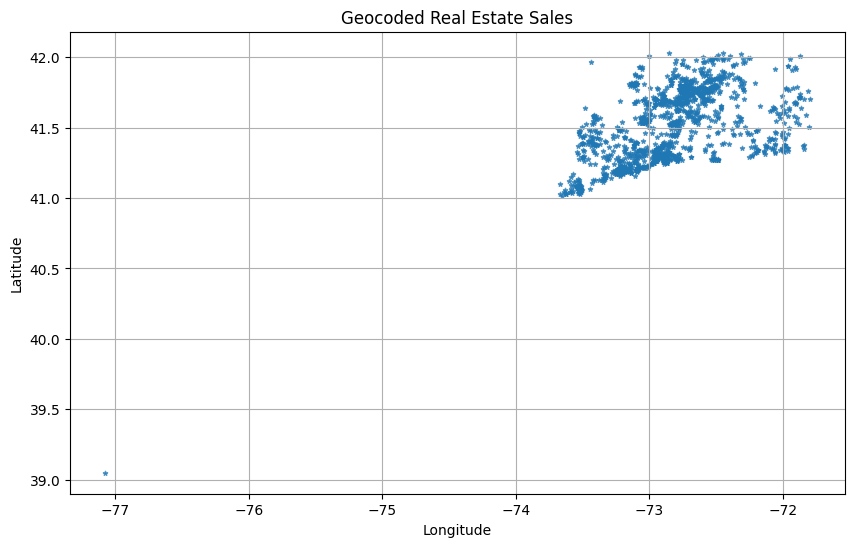

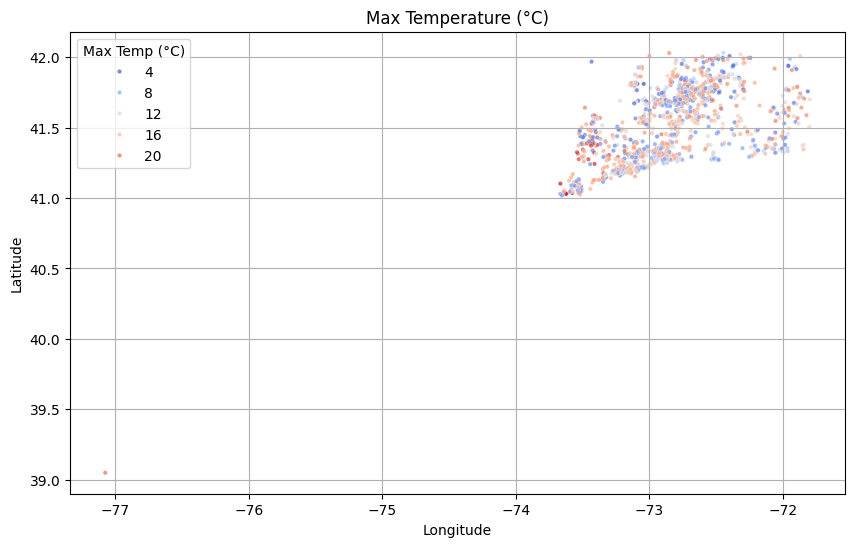

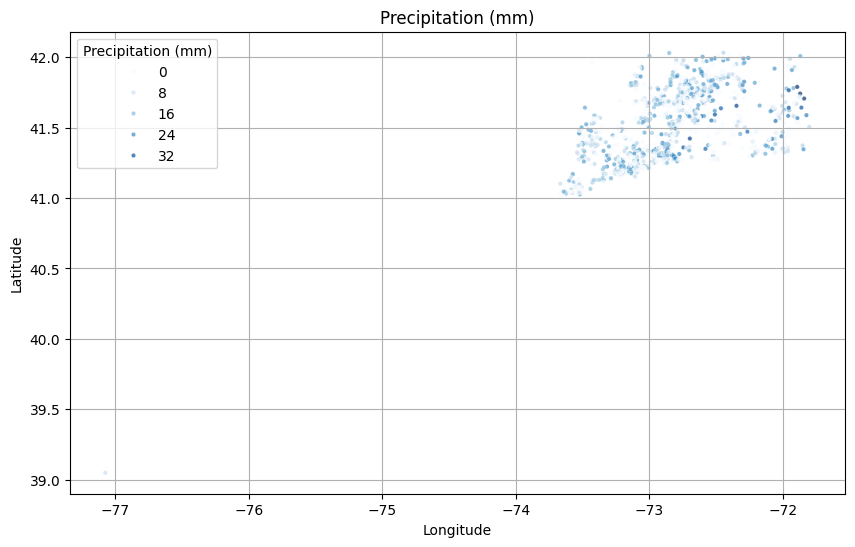

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#loading enhanced generated dataset
df = pd.read_csv('/content/enhanced_real_estate_april_2019.csv')

#make sure values are numeric
df['Max_Temperature_C'] = pd.to_numeric(df['Max_Temperature_C'], errors='coerce')
df['Precipitation_mm'] = pd.to_numeric(df['Precipitation_mm'], errors='coerce')

#Plot for geocodes
plt.figure(figsize=(10, 6))
plt.scatter(df['Longitude'], df['Latitude'], marker = '*', s=10, alpha=0.7)
plt.title('Geocoded Real Estate Sales')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

#Plotting Max Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='Longitude', y='Latitude',
    hue='Max_Temperature_C', palette='coolwarm', s=10, alpha=0.7
)
plt.title("Max Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Max Temp (°C)")
plt.grid(True)
plt.show()

#Plotting Max Precipitation
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='Longitude', y='Latitude',
    hue='Precipitation_mm', palette='Blues', s=10, alpha=0.7
)
plt.title("Precipitation (mm)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Precipitation (mm)")
plt.grid(True)
plt.show()
